## Contents
* [1. Optimise Pre-Processing & Vectoriser](#1.-Optimise-Pre-Processing-&-Vectoriser)
* [2. Imports](#2.-Imports)
* [3. Data Cleaning & Preparation](#3.-Data-Cleaning-&-Preparation)
* [4. Model Fit & Predict](#4.-Model-Fit-&-Predict)
    * [4.1 Alternate 1](#4.1-Alternate-1)
    * [4.2 Alternate 2](#4.2-Alternate-2)
    * [4.3 Alternate 3](#4.3-Alternate-3)
* [5. Remarks](#5.-Remarks)

---
## 1. Optimise Pre-Processing & Vectoriser
---
Objective: to compare the following models to determine the best combination of pre-processing and vectoriser, before deciding on the best model to use:

|                | Baseline Model          | Alternate 1             | Alternate 2                                       | Alternate 3                                       |
|----------------|-------------------------|-------------------------|---------------------------------------------------|---------------------------------------------------|
| Pre-processing | - Basic cleaning        | - Basic cleaning        | - Basic cleaning<br>- Remove duplicated sentences | - Basic cleaning<br>- Remove duplicated sentences |
| Vectoriser     | CountVectoriser         | TFIDF                   | CountVectoriser                                   | TFIDF                                             |
| Model          | Multinomial Naive Bayes | Multinomial Naive Bayes | Multinomial Naive Bayes                           | Multinomial Naive Bayes                           |

Note: the code below was ran on Kaggle, to make use of Kaggle GPUs.

---
## 2. Imports
---

In [128]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

---
## 3. Data Cleaning & Preparation
---

- read CSV files

In [129]:
kf_df = pd.read_csv('/kaggle/input/sq-services/kf_clean.csv')
lca_df = pd.read_csv('/kaggle/input/sq-services/LCA_clean.csv')
other_df = pd.read_csv('/kaggle/input/sq-services/other_clean.csv')
kf_df.head()

,text,source
0,Qualifying as EG for the first time,kf
1,Which FFP for me? Master Discussion,kf
2,#SQMelbourneTram,kf
3,Advice sought - Changing redemption bookings,kf
4,First Savers SYD-SIN,kf


- prepare df to remove duplicated sentences (for alternate 2 and 3 approaches)
- tokenise text into sentences, remove duplicate sentences
    - in the SQTalk forum, when person A replies to person B's comment, person A's comment will start with a word-for-word quote of person B's comment
    - the strategy is to tokenise the text by sentences, then remove any repeated sentences to remove such repetitive quotes

In [130]:
# for kf dataset
temp_df = []

for text in kf_df['text']:
    for sent in sent_tokenize(str(text)):
        temp_df.append(sent)

kf_sent_df = pd.DataFrame(data=temp_df, columns=['sent'])
print(f"kf_df had {kf_sent_df.shape[0]} rows")
kf_sent_df.drop_duplicates(inplace=True)
print(f"After removing duplicates, kf_df has {kf_sent_df.shape[0]} rows")

# for lca dataset
temp_df = []

for text in lca_df['text']:
    for sent in sent_tokenize(str(text)):
        temp_df.append(sent)

lca_sent_df = pd.DataFrame(data=temp_df, columns=['sent'])
print(f"lca_df had {lca_sent_df.shape[0]} rows")
lca_sent_df.drop_duplicates(inplace=True)
print(f"After removing duplicates, lca_df has {lca_sent_df.shape[0]} rows")

# for other dataset
temp_df = []

for text in other_df['text']:
    for sent in sent_tokenize(str(text)):
        temp_df.append(sent)

other_sent_df = pd.DataFrame(data=temp_df, columns=['sent'])
print(f"other_df had {other_sent_df.shape[0]} rows")
kf_sent_df.drop_duplicates(inplace=True)
print(f"After removing duplicates, other_df has {other_sent_df.shape[0]} rows")

kf_df had 60029 rows
After removing duplicates, kf_df has 52412 rows
lca_df had 29538 rows
After removing duplicates, lca_df has 26655 rows
other_df had 48456 rows
After removing duplicates, other_df has 48456 rows


- reassign 'source' column, and combine into 1 dataframe

In [131]:
kf_sent_df['source'] = 'kf'
lca_sent_df['source'] = 'lca'
other_sent_df['source'] = 'other'

services_df = pd.concat([kf_sent_df, lca_sent_df, other_sent_df])
services_df.shape

(127523, 2)

- check for and resolve any NA values

In [132]:
print(services_df.isna().sum())

# acceptable to drop 3 NA values out of 44k values
services_df.dropna(inplace=True)
# reset index, and drop old index
services_df.reset_index(drop=True, inplace=True)

print(services_df.isna().sum())

sent      0
source    0
dtype: int64
sent      0
source    0
dtype: int64


- create a 'kf' column: 
    - if value = 0, the source is others
    - if value = 1, the source is kf
    - if value = 2, the source is from LCA

In [133]:
services_df['y_true'] = services_df['source'].map({'other':0, 'kf': 1, 'lca': 2})
print(services_df.head())
services_df['y_true'].value_counts(normalize=True)

                                           sent source  y_true
0           Qualifying as EG for the first time     kf       1
1                             Which FFP for me?     kf       1
2                             Master Discussion     kf       1
3                              #SQMelbourneTram     kf       1
4  Advice sought - Changing redemption bookings     kf       1


1    0.411000
0    0.379979
2    0.209021
Name: y_true, dtype: float64

- add selected words to stopwords, taken from ["SQTalk Abbreviations, Slangs, Definitions, Phrases"](http://www.sqtalk.com/forum/forum/general/sqtalk-community/1010-) thread
- the thread only contained a few more stop words (added below). I scanned through the forum manually, and noticed that the comments were largely in proper English (i.e. properly spelled, without use of Singlish). This may be due to the possible more affluent customer base of SIA

In [134]:
cvec = CountVectorizer(max_features = 500, stop_words = 'english') 
custom_stopwords = [word for word in cvec.get_stop_words()]
custom_stopwords.extend(['btw','iirc','imo','imho'])

- prepare untreated df (for alternate 1 approach)

In [135]:
services_untreated_df = pd.concat([kf_df, lca_df, other_df])

print(services_untreated_df.isna().sum())

# acceptable to drop 3 NA values out of 44k values
services_untreated_df.dropna(inplace=True)
# reset index, and drop old index
services_untreated_df.reset_index(drop=True, inplace=True)

print(services_untreated_df.isna().sum())

text      3
source    0
dtype: int64
text      0
source    0
dtype: int64


- create a 'kf' column: 
    - if value = 0, the source is others
    - if value = 1, the source is kf
    - if value = 2, the source is from LCA

In [136]:
services_untreated_df['y_true'] = services_untreated_df['source'].map({'other':0, 'kf': 1, 'lca': 2})
services_untreated_df['y_true'].value_counts(normalize=True)

1    0.402724
0    0.353570
2    0.243706
Name: y_true, dtype: float64

---
## 4. Model Fit & Predict
---

## 4.1 Alternate 1
### - using TFIDF and Multinomial NB

In [137]:
X = services_untreated_df['text']
y = services_untreated_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train

13477    Does KF actually explain the differences in qu...
29195    BKK airport closed: SQ et al Cancel flights 26...
22061    Originally posted by SQ LPPView PostThat's a v...
6624     Originally posted by GLAM82View PostIs there a...
20643    I would have thought they will use the SKL, sa...
                               ...                        
12020    Originally posted by CGKView Post SQ prefers I...
43382    I thought I'd get your views on this, which is...
1598     Originally posted by florianwagnerView PostSo ...
11541             letter dated 19 March received 28 March.
22264    Sorry to report that as I got to SFO airport f...
Name: text, Length: 33095, dtype: object

- tokenise with TFIDF

In [138]:
tvec = TfidfVectorizer(max_features = 500, stop_words = 'english') 
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

- instantiate and fit a Naive Bayes model

In [139]:
nb = MultinomialNB()
NB_model = ovr(nb).fit(X_train_cvec, y_train)  # using OneVsRestClassifier

- visualise confusion matrix

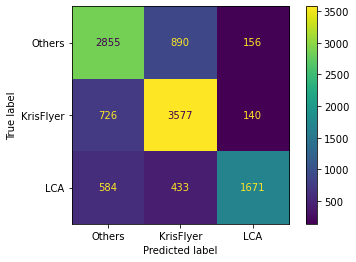

In [140]:
y_pred = NB_model.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [141]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      3901
           1       0.73      0.81      0.77      4443
           2       0.85      0.62      0.72      2688

    accuracy                           0.73     11032
   macro avg       0.75      0.72      0.73     11032
weighted avg       0.74      0.73      0.73     11032



- display the weighted average ROC AUC score

In [142]:
y_pred_prob = NB_model.predict_proba(X_test_cvec)

roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

0.8894240154264128

- weighted f1-score of KrisFlyer and LCA

In [143]:
f1_score(y_test, y_pred, labels=[1,2], average = 'weighted')

0.7477005334604189

## 4.2 Alternate 2
### - using removed duplicated sentences, CountVectoriser and Multinomial NB

- train-test split our df

In [144]:
X = services_df['sent']
y = services_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train

42965                              Had abs no idea on tat..
35656     Originally posted by 9V-JKLView PostIn case yo...
68074     Is Shi Quan Shi Mei still on the menu?If there...
75861     But again some people have bigger appetite for...
50226                            but MI do not fly HKG-SIN?
                                ...                        
27305                 Savers redemptions are a dying breed.
105424                        Maybe it's because it's a Mac
72372     Preferably on one of their aircraft with quirk...
116065    Would love to see the Christmas lights again.....
89638     Daniel is serving in the navy and is looking t...
Name: sent, Length: 95642, dtype: object

- tokenise with Count Vectoriser

In [145]:
cvec = CountVectorizer(max_features = 500, stop_words = custom_stopwords) 
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

- instantiate and fit a Naive Bayes model

In [146]:
nb = MultinomialNB()
NB_model = ovr(nb).fit(X_train_cvec, y_train)  # using OneVsRestClassifier

- visualise confusion matrix

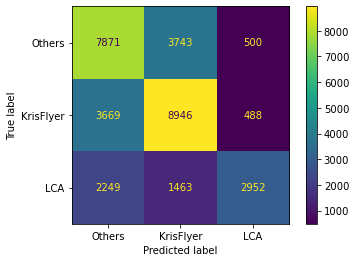

In [147]:
y_pred = NB_model.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [148]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.57      0.65      0.61     12114
           1       0.63      0.68      0.66     13103
           2       0.75      0.44      0.56      6664

    accuracy                           0.62     31881
   macro avg       0.65      0.59      0.61     31881
weighted avg       0.63      0.62      0.62     31881



- display the weighted average ROC AUC score

In [149]:
y_pred_prob = NB_model.predict_proba(X_test_cvec)

roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

0.7899255227302375

- weighted f1-score of KrisFlyer and LCA

In [150]:
f1_score(y_test, y_pred, labels=[1,2], average = 'weighted')

0.6228565466017535

## 4.3 Alternate 3
### - using removed duplicated sentences, TFIDF and Multinomial NB

- tokenise with TFIDF

In [151]:
tvec = TfidfVectorizer(max_features = 500, stop_words = custom_stopwords)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

- instantiate and fit a Naive Bayes model

In [152]:
nb = MultinomialNB()
NB_model = ovr(nb).fit(X_train_cvec, y_train)  # using OneVsRestClassifier

- visualise confusion matrix

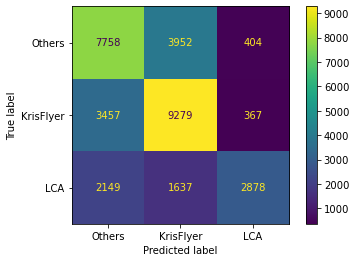

In [153]:
y_pred = NB_model.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', 'KrisFlyer', 'LCA'])
disp.plot();

- display precision, recall, f1-score of each class

In [154]:
print(classification_report(y_test, y_pred))
# 0: other, 1: kf, 2: lca

              precision    recall  f1-score   support

           0       0.58      0.64      0.61     12114
           1       0.62      0.71      0.66     13103
           2       0.79      0.43      0.56      6664

    accuracy                           0.62     31881
   macro avg       0.66      0.59      0.61     31881
weighted avg       0.64      0.62      0.62     31881



- display the weighted average ROC AUC score

In [155]:
y_pred_prob = NB_model.predict_proba(X_test_cvec)

roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

0.8011750361899902

- weighted f1-score of KrisFlyer and LCA

In [156]:
f1_score(y_test, y_pred, labels=[1,2], average = 'weighted')

0.6279590697763052

---
## 5. Remarks
---

|                                     | Baseline Model | Alternate 1<br>\*Best performance\* | Alternate 2 | Alternate 3 |
|-------------------------------------|----------------|-------------|-------------|-------------|
| Pre-processing | - Basic cleaning        | - Basic cleaning        | - Basic cleaning<br>- Remove duplicated sentences | - Basic cleaning<br>- Remove duplicated sentences |
| Vectoriser     | CountVectoriser         | TFIDF                   | CountVectoriser                                   | TFIDF                                             |
| Model          | Multinomial Naive Bayes | Multinomial Naive Bayes | Multinomial Naive Bayes                           | Multinomial Naive Bayes                           |
| Weighted-average ROC AUC            | 0.877          | 0.889       | 0.790       | 0.801       |
| Weighted-average f1-score (kf, lca) | 0.743          | 0.748       | 0.623       | 0.628       |

- Alternate 1 combination of preprocessing and vectoriser performed the best, and will be used for the next step of finding the best model
<br>
<br>
- TFIDF had a slightly better performance than CountVectoriser (baseline vs alt 1, alt2 vs alt 3)
<br>
<br>
- The removal of duplicated sentences seemed to have an adverse effect on model performance. This suggested that the quotes contain valuable key words that deserved to be emphasised (i.e. the comments that people usually reply to contain valuable key words)